# Import and misc

In [ ]:
# Instal latest torch and torchaudio

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd
import math

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt



In [3]:
import random

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seed()

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 130
    streaming_step_size = 40
    t: int = 10
    target_loss_w: float = 0.5


# Quality measurment functions:

In [50]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)


def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

In [ ]:
!pip install thop

In [52]:
import tempfile
import time

from thop import profile


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t}")


def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

# Data

In [6]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 15:45:01--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.127.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   245MB/s    in 5.9s    

2022-11-06 15:45:07 (240 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [7]:
metadata = torchaudio.info("speech_commands/bed/00176480_nohash_0.wav")
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=16000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [8]:
from pickle import FALSE
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None,
        return_path: bool = False
    ):        
        self.transform = transform
        self.return_path = return_path

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        if self.return_path:
            return {
                'wav': wav,
                'keyword': instance['keyword'],
                'label': instance['label'],
                'path': path2wav
            }
        return {
                'wav': wav,
                'keyword': instance['keyword'],
                'label': instance['label'],
            }

    def __len__(self):
        return len(self.csv)

In [9]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/two/f4cae173_nohash_0.wav,two,0
1003,speech_commands/happy/d3a18257_nohash_1.wav,happy,0
38126,speech_commands/right/471a0925_nohash_0.wav,right,0
144,speech_commands/happy/518588b6_nohash_1.wav,happy,0
31651,speech_commands/go/5588c7e6_nohash_0.wav,go,0


In [10]:
my_dataset = SpeechCommandDataset(
    path2dir='my_dataset', keywords=TaskConfig.keyword,
    return_path=True
)
my_dataset.csv

,path,keyword,label


### Augmentations

In [11]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [12]:
set_random_seed()
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [13]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [14]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [15]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [16]:
class Collator:
    
    def __call__(self, data):
        wavs, labels, paths = [], [], []

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])
            try:
                paths.append(el['path'])
            except:
              continue

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        if len(paths) == len(wavs):
            return wavs, labels, paths
        return wavs, labels

###  Dataloaders

In [17]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

my_loader = DataLoader(my_dataset, batch_size=1,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [18]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [19]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

# Models

In [20]:
class SmallAttention(nn.Module):
    def __init__(self, hidden_size: int, scale: int = 2):
        assert hidden_size >= scale
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // scale),
            nn.Tanh(),
            nn.Linear(hidden_size // scale, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


class StreamingCRNNPrev(CRNN, nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__(config)
        self.buffer = None
        self.last_hidden = None
        self.streaming_mode = True
        self.gru_output_buffer = None
    
    def flush(self):
        self.buffer = None
        self.gru_output_buffer = None
        self.last_hidden = None
        self.streaming_mode = False

    def forward(self, input):
        if self.training or not self.streaming_mode:
            output = super().forward(input)
            
        else:   
            n_input_frames = input.size()[-1]

            # набираем буфер (чтобы размерности были больше kernel_size)
            if self.buffer is None:
                self.buffer = input.unsqueeze(dim=1)
                return None
            elif self.buffer.size()[-1] < self.config.kernel_size[1]:  # self.config.max_window_length:  
                self.buffer = torch.cat((
                    self.buffer,
                    input.unsqueeze(dim=1)
                    ),
                    dim=-1
                )
                return None
            # добавляем в буфер новые фреймы + оставляем kernel_size - 1 пердыдущих
            # чтобы первый фрейм входа был связан с предыдущими
            else:
                self.buffer = torch.cat((
                    self.buffer[:, :, :, -(self.config.kernel_size[1] - 1):],  # -(self.config.max_window_length - n_input_frames):],
                    input.unsqueeze(dim=1)
                    ), 
                    dim=-1
                )
            conv_output = self.conv(self.buffer).transpose(-1, -2)

            # применяем gru и сохраняем hidden_state (gru)
            if self.last_hidden is None:
                gru_output, self.last_hidden = self.gru(conv_output)
            else:
                gru_output, self.last_hidden = self.gru(conv_output, self.last_hidden)

            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
        return output


class StreamingCRNN(CRNN, nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__(config)
        self.buffer = torch.tensor([])
        self.last_hidden = torch.tensor([])
        self.gru_chunk_buffer: List[torch.tensor] = []
        self.streaming_mode = True

    def forward(self, input, flush=False, max_window_length=101, streaming_step_size=40):
        if self.training or not self.streaming_mode:
            # output = super().forward(input)
            input = input.unsqueeze(dim=1)
            conv_output = self.conv(input).transpose(-1, -2)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
            
        else: 
            if flush:
                self.buffer = torch.tensor([])
                self.last_hidden = torch.tensor([])
                self.gru_chunk_buffer = []
                self.streaming_mode = True

            n_input_frames = input.size()[-1]
            max_chunk_n = max_window_length // streaming_step_size

            # набираем буфер (чтобы размерности были больше kernel_size)
            if len(self.buffer) == 0:
                self.buffer = input.unsqueeze(dim=1)
                return None
            elif self.buffer.size()[-1] < self.conv[0].kernel_size[1] - 1:  # self.config.max_window_length:  
                self.buffer = torch.cat((
                    self.buffer,
                    input.unsqueeze(dim=1)
                    ),
                    dim=-1
                )
                return None
            # добавляем в буфер новые фреймы + оставляем kernel_size - 1 пердыдущих
            # чтобы первый фрейм входа был связа с предыдущими
            else:
                self.buffer = torch.cat((
                    self.buffer[:, :, :, -(self.conv[0].kernel_size[1] - 1):],
                    input.unsqueeze(dim=1)
                    ), 
                    dim=-1
                )
            conv_output = self.conv(self.buffer).transpose(-1, -2)

            # применяем gru и сохраняем hidden_state (gru)
            if len(self.last_hidden) == 0:
                gru_output, self.last_hidden = self.gru(conv_output)
            else:
                gru_output, self.last_hidden = self.gru(conv_output, self.last_hidden)

            # заполняем буфер выходов gru
            if len(self.gru_chunk_buffer) == 0:
                self.gru_output_buffer = [gru_output]
            else:
                self.gru_output_buffer.append(gru_output)
                self.gru_output_buffer = self.gru_output_buffer[-max_chunk_n:]
            
            contex_vector = self.attention(torch.cat(self.gru_output_buffer, dim=-2))
            output = self.classifier(contex_vector)
        return output

# Training Functions

In [21]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc


def train_distillation_epoch(model, teacher, opt, loader, log_melspec, device, t=1, target_loss_w=0.5):
    model.train(), teacher.eval()

    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)

        with torch.no_grad():
            teacher_logits = teacher(batch)
            teacher_probs = F.softmax(teacher_logits / t, dim=-1)

        distill_loss = F.kl_div(torch.log(F.softmax(logits / t, dim=-1)), torch.log(teacher_probs), reduction='batchmean')
        target_loss = F.cross_entropy(logits, labels)
        loss = target_loss_w * target_loss + (1 - target_loss_w) * distill_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [46]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)

        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr


def train(model, config, opt, teacher=None):
    history = defaultdict(list)
    for n in range(config.num_epochs):
        if teacher is None:
            train_epoch(model, opt, train_loader,
                        melspec_train, config.device)
        else:
            train_distillation_epoch(model, teacher, opt, train_loader,
                melspec_train, config.device,
                t=config.t, target_loss_w=config.target_loss_w)

        au_fa_fr = validation(model, val_loader,
                              melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)
    return history

# Streaming Model Training

In [ ]:
set_random_seed()
history = defaultdict(list)
streaming_config = TaskConfig(
    hidden_size=32,
    num_epochs=20
)
streaming_model = StreamingCRNN(streaming_config).to(streaming_config.device)
streaming_model.streaming_mode = False

print(streaming_model)

streaming_opt = torch.optim.Adam(
    streaming_model.parameters(),
    lr=streaming_config.learning_rate,
    weight_decay=streaming_config.weight_decay
)

StreamingCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


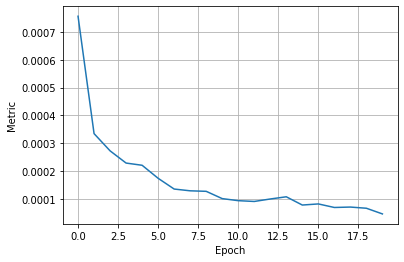

END OF EPOCH 19


In [ ]:
train(streaming_model, streaming_config, streaming_opt)

In [ ]:
torch.save(streaming_model.state_dict(), "streaming_model_state_dict")

# Streaming Model Inference

In [ ]:
streaming_config = TaskConfig(hidden_size=32)

streaming_model = StreamingCRNN(streaming_config).to(streaming_config.device)
streaming_model.load_state_dict(torch.load("streaming_model_state_dict"))

streaming_model.eval()
streaming_model.streaming_mode = True
streaming_melspec = LogMelspec(is_train=False, config=streaming_config)
max_window_length = 101
streaming_step_size = 40

probs_history = defaultdict(list)
for obj, label, path in my_loader:

    obj, label = obj.to(streaming_config.device), label.to(streaming_config.device)
    obj = obj[:, 1::3]  # sample rate 16000 from 48000
    batch = streaming_melspec(obj)

    for i in range(0, batch.size()[-1], streaming_step_size):
        chunk = batch[:, :, i : i + streaming_step_size]

        flush = True if i == 0 else False
        output = streaming_model(chunk, flush, max_window_length, streaming_step_size)

        if output is not None:
            probs = F.softmax(output, dim=-1)

            argmax_probs = torch.argmax(probs, dim=-1)
            probs_history[path[0]].append(probs[:, 1].cpu().item())

In [ ]:
title_dict = {
    "my_dataset/sheila/sheila_alphabet.wav": ["abc...xyz Sheila abc...xyz", "Sheila"],
    "my_dataset/sheila/friend_sheila.wav": ["My friend's name is Sheila. She is very kind and beautiful", "Sheila"],
    "my_dataset/sheila/sheila.wav": ["Sheila", "Sheila"],
    "my_dataset/sheila/sheila_ones.wav": ["one one ... one Sheila one ... one one", "Sheila"],
    "my_dataset/not_sheila/alphabet.wav": ["abc...xyz abc...xyz", "not Sheila"],
    "my_dataset/not_sheila/friend_alex.wav": ["My friend's name is Alex. He is very kind and funny", "not Sheila"]
}

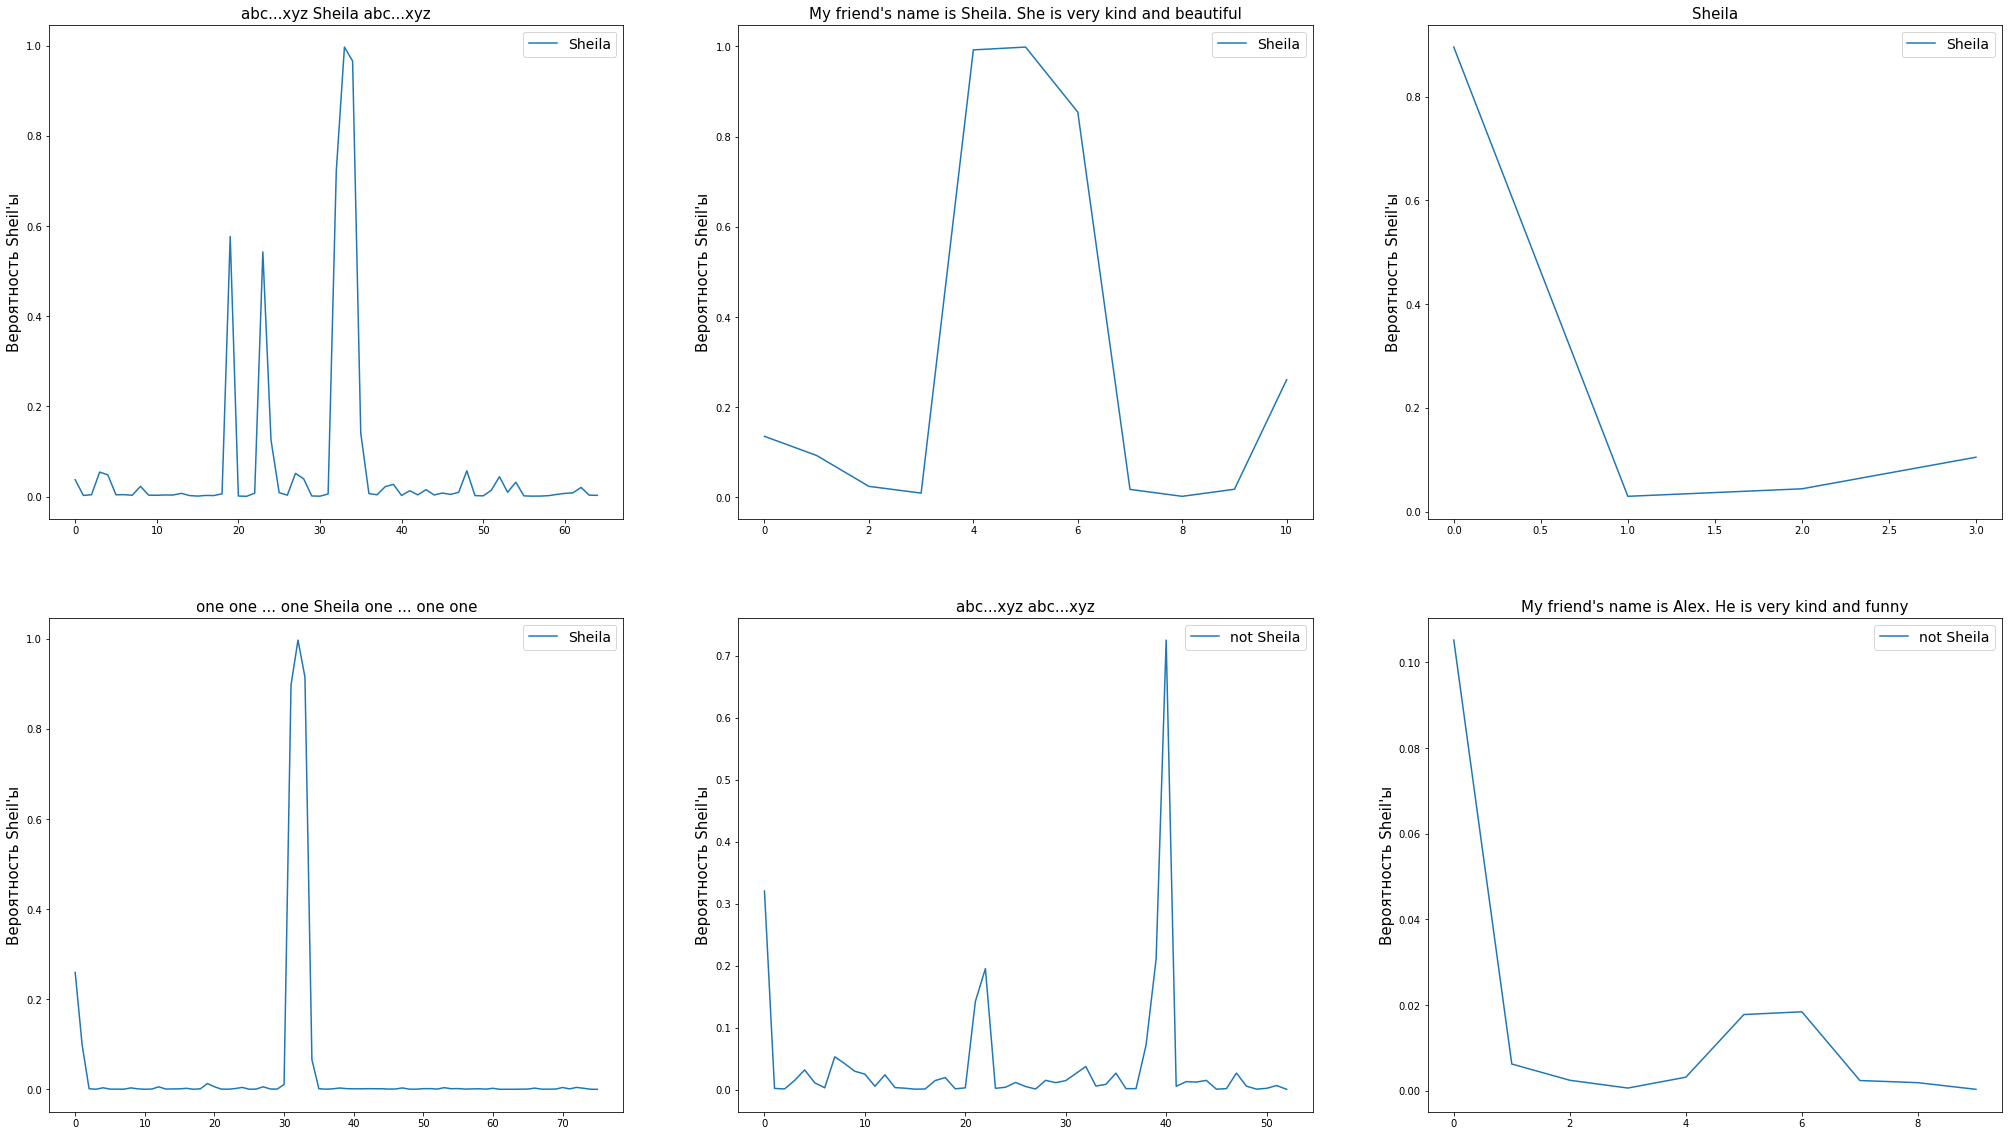

In [ ]:
fig, axs = plt.subplots((len(probs_history) + 2) // 3, 3, figsize=(35,20))
for i, path in enumerate(probs_history):
    raw, col = i // 3, i - (i // 3) * 3
    axs[raw, col].plot(range(len(probs_history[path])), probs_history[path] , label=title_dict[path][1])
    axs[raw, col].legend(fontsize=14)
    axs[raw, col].set_title(title_dict[path][0], fontsize=15)
    axs[raw, col].set_ylabel("Вероятность Sheil'ы", fontsize=15)
plt.show()

# Training

In [ ]:
set_random_seed()
teacher_config = TaskConfig(hidden_size=32)
teacher = CRNN(teacher_config).to(teacher_config.device)

print(teacher)

teacher_opt = torch.optim.Adam(
    teacher.parameters(),
    lr=teacher_config.learning_rate,
    weight_decay=teacher_config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in teacher.parameters()])

25387

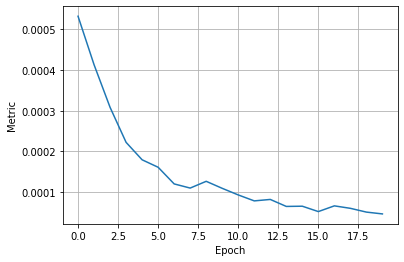

END OF EPOCH 19


In [ ]:
teacher_history = train(teacher, teacher_config, teacher_opt)

In [ ]:
teacher_history

defaultdict(list,
            {'val_metric': [0.0005324783031159102,
              0.0004132287998023548,
              0.0003083610861593027,
              0.00022228517984920307,
              0.0001794083504788435,
              0.0001610402390241508,
              0.00012009092752249355,
              0.00010986255096845093,
              0.00012648813852945604,
              0.0001092240233772709,
              9.300422905178205e-05,
              7.834196464496597e-05,
              8.190459055089564e-05,
              6.471208596968395e-05,
              6.526110034714716e-05,
              5.2037014907381424e-05,
              6.610849210366645e-05,
              6.004546376124678e-05,
              5.077487859397418e-05,
              4.629623413434233e-05]})

In [ ]:
torch.save(teacher, '/content/drive/MyDrive/teacher')
torch.save(teacher_history, '/content/drive/MyDrive/teacher_history')

# MACs and Memory Dependence on hidden_size и cnn_out_channels

In [ ]:
models_metadata = defaultdict(dict)
tmp_config = TaskConfig()

inp = torch.randn(1, 2 * 16_000)
melspec_tmp = LogMelspec(is_train=False, config=tmp_config) 
spec = melspec_tmp(inp.to(tmp_config.device))

n_chs = [2, 4, 6, 8]
hid_ss = [2, 4, 8, 16, 24]

for n_ch in n_chs:
    for hid_s in hid_ss:

        tmp_config.cnn_out_channels = n_ch
        tmp_config.hidden_size = hid_s
        tmp = CRNN(tmp_config).to(tmp_config.device)

        macs = profile(tmp, (spec, ))[0]
        memory = get_size_in_megabytes(tmp) * 10**3

        models_metadata[f"n_ch{n_ch}hid_s{hid_s}"] = {"macs": macs, "memory": memory}

torch.save(models_metadata, '/content/drive/MyDrive/models_metadata')

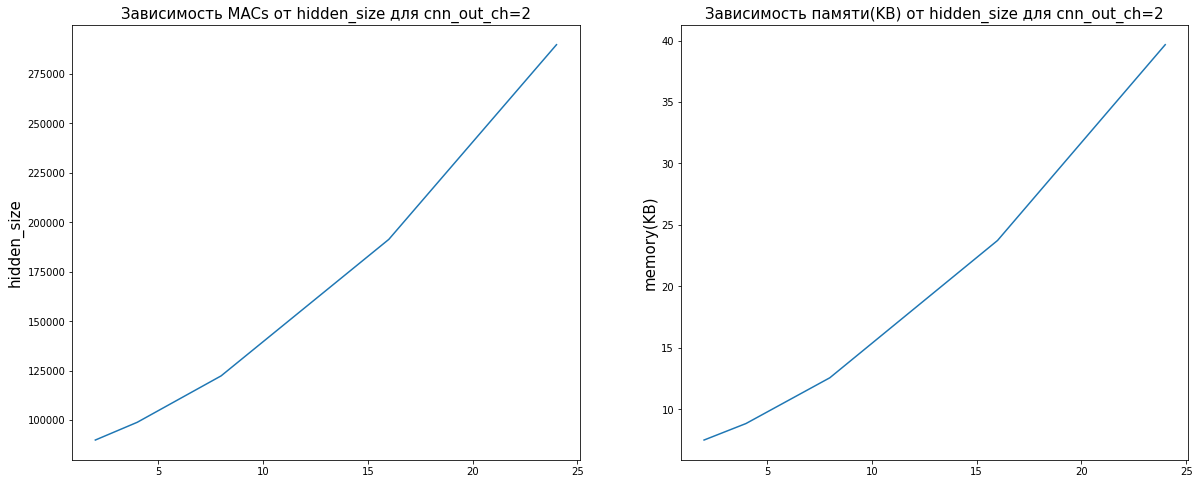

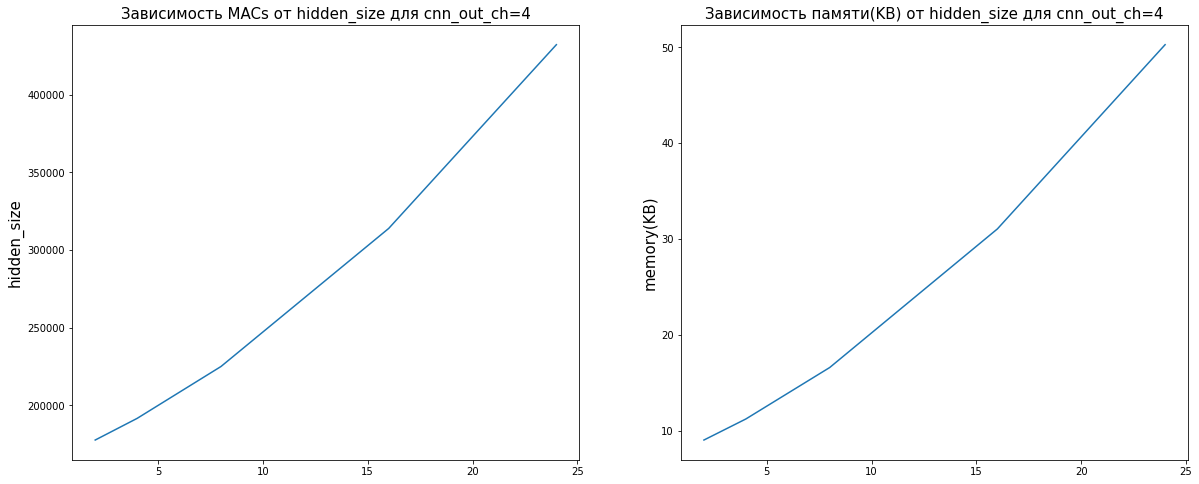

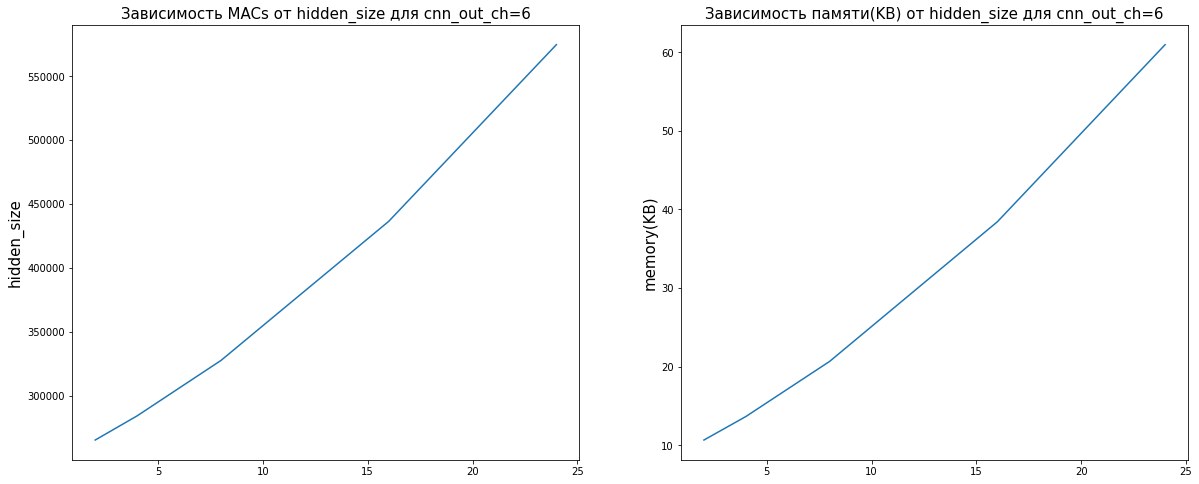

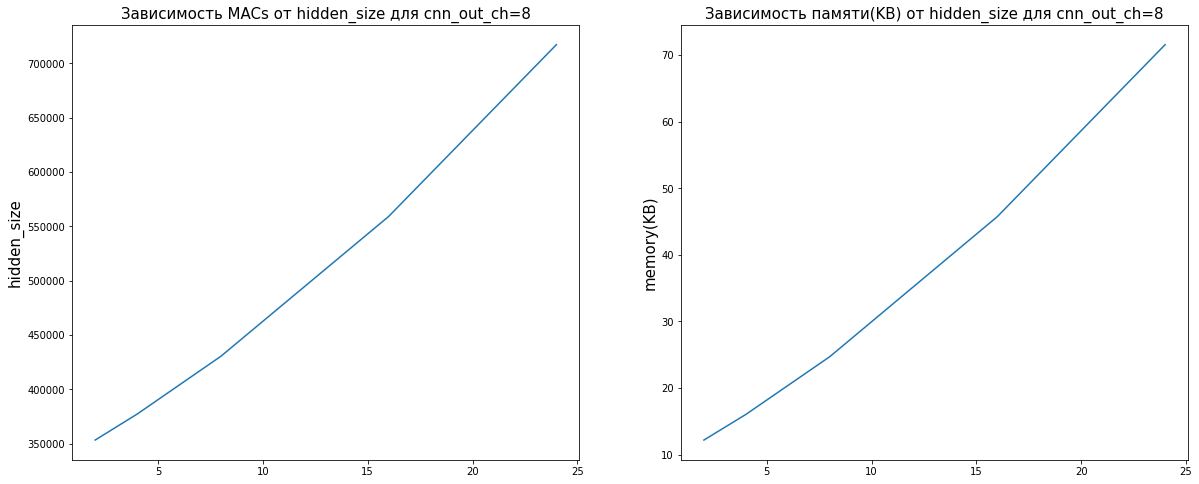

In [ ]:
for n_ch in n_chs:
    n_ch_macs, n_ch_memory = [], []
    for hid_s in hid_ss:
        n_ch_macs.append(models_metadata[f"n_ch{n_ch}hid_s{hid_s}"]["macs"])
        n_ch_memory.append(models_metadata[f"n_ch{n_ch}hid_s{hid_s}"]["memory"])

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(hid_ss, n_ch_macs)
    axs[0].set_title(f"Зависимость MACs от hidden_size для cnn_out_ch={n_ch}", fontsize=15)
    axs[0].set_ylabel("MACs", fontsize=15)
    axs[0].set_ylabel("hidden_size", fontsize=15)

    axs[1].plot(hid_ss, n_ch_memory)
    axs[1].set_title(f"Зависимость памяти(KB) от hidden_size для cnn_out_ch={n_ch}", fontsize=15)
    axs[1].set_ylabel("memory", fontsize=15)
    axs[1].set_ylabel("memory(KB)", fontsize=15)

    plt.show()

In [ ]:
for n_ch in n_chs:
    plt.plot(hid_ss, )


# Dark Knowledge Distillation

В этом эксперименте дистиллируем меньшую модель. У модели-ученика следующие параметры отличаются от модели-учителя:

$\star$ `hidden_size`: 16
    
$\star$ `cnn_out_channels`: 4

Дистилляция происходит за счёт нового лосса:

$L = \alpha L_{\text{target}} + (1 - \alpha)L_{\text{distill}}(logits_{s}, logits_{t}) = \alpha NLL(logits_{s}, target) + (1 - \alpha)D_{KL}(logits_{s}, logits_{t})$

В данном эксперименте $\alpha = 0.3$

При этом в $L_{target}$ logit'ы получались софтмаксом с <u>температурой 1</u> от выходов модели, а в $L_{distill}$ <u>температура равна 10</u> 


Обучение длилось 70 эпох (по 30 секунд каждая), хотя уже на ~40 эпохе модель достигла необходимого качества.


**Результаты:** 

MACs ratio   | teacher : student = 2.88

Memory ratio | teacher : student = 3.30

## Trainig

In [ ]:
teacher = torch.load('/content/drive/MyDrive/teacher')
teacher_history = torch.load('/content/drive/MyDrive/teacher_history')

In [ ]:
set_random_seed()
student_config = TaskConfig(
    cnn_out_channels=4,
    hidden_size=16,
    num_epochs=70,
    t=10,
    target_loss_w=0.3
)

student = CRNN(student_config).to(student_config.device)

student_opt = torch.optim.Adam(
            student.parameters(),
            lr=student_config.learning_rate,
            weight_decay=student_config.weight_decay
        )

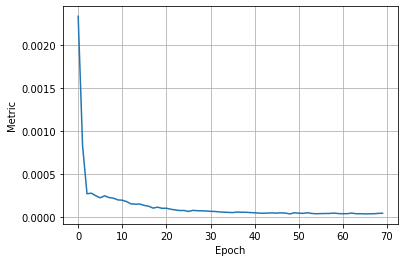

END OF EPOCH 69


In [ ]:
student_history = train(student, student_config, student_opt, teacher)

In [ ]:
student_history

defaultdict(list,
            {'val_metric': [0.0023335348872528857,
              0.0008277167521443264,
              0.00026857544643596427,
              0.0002742326815428677,
              0.0002446992885638962,
              0.00022118715109427663,
              0.00024420994966224425,
              0.00022387254750578142,
              0.00021641908057696036,
              0.00019622489956244444,
              0.00019308000198719336,
              0.00017643651178344484,
              0.00014943335897886907,
              0.00014723133392143515,
              0.00014783405622712843,
              0.00013210360080329156,
              0.0001225197193880101,
              0.00010094703488225505,
              0.0001119690952645869,
              9.847050263608954e-05,
              9.981916838942307e-05,
              8.768117660942147e-05,
              7.97503058741107e-05,
              7.285778841791511e-05,
              7.325761410585027e-05,
              6.216394315254499

In [ ]:
torch.save(student_history, '/content/drive/MyDrive/student_history')
torch.save(student, '/content/drive/MyDrive/student')

## Validation

In [ ]:
student = torch.load('/content/drive/MyDrive/student')
student_history = torch.load('/content/drive/MyDrive/student_history')

In [ ]:
validation(student, val_loader, melspec_val, device="cuda:0")

100%|██████████| 102/102 [00:05<00:00, 17.35it/s]


4.121188359522662e-05

In [ ]:
inp = torch.randn(1, 2 * 16_000)
spec = melspec_train(inp.to("cuda:0"))

with Timer(name='first', verbose=True):
    student(spec)

student_macs = profile(student, (spec, ))[0]
student_macs

First | Elapsed time : 0.002969503402709961
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


313936.0

In [ ]:
teacher = torch.load('/content/drive/MyDrive/teacher')

In [ ]:
inp = torch.randn(1, 2 * 16_000)
spec = melspec_train(inp.to("cuda:0"))

with Timer(name='first', verbose=True):
    teacher(spec)

teacher_macs = profile(teacher, (spec, ))[0]
teacher_macs

First | Elapsed time : 0.002969503402709961
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


904608.0

In [ ]:
print(f"MACs ratio | teacher : student = {teacher_macs / student_macs}")

MACs ratio | teacher : student = 2.8815045104734724


In [ ]:
teacher_mb = get_size_in_megabytes(teacher)
student_mb = get_size_in_megabytes(student)
print(f"Memory | teacher : student = {teacher_mb/student_mb}")

Memory | teacher : student = 3.2976475646459065


# Dark Knowledge Distillation + Attention Distillation

В этом эксперименте дистиллируется не только основная модель, но и её отдельный блок - `attention`.

В этот блок помещается объект класса `SmallAttention`, который отличается от изначального тем, что кол-во признаков на выходе первого линейного слоя уменьшается в `scale=4` раза.


**Результаты:** 

MACs ratio   | teacher : attn_student = 2.93

Memory ratio | teacher : attn_student = 3.39

## Training

In [53]:
teacher = torch.load('/content/drive/MyDrive/teacher')

In [54]:
set_random_seed()
attn_student_config = TaskConfig(
    hidden_size=8,
    cnn_out_channels=4,
    num_epochs=70,
    t=10,
    target_loss_w=0.3
)

attn_student = CRNN(attn_student_config).to(attn_student_config.device)
attn_student.attention = SmallAttention(attn_student_config.hidden_size, scale=4)
attn_student.attention.to(attn_student_config.device)

print(attn_student)

attn_student_opt = torch.optim.Adam(
    attn_student.parameters(),
    lr=attn_student_config.learning_rate,
    weight_decay=attn_student_config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 8, num_layers=2, batch_first=True, dropout=0.1)
  (attention): SmallAttention(
    (energy): Sequential(
      (0): Linear(in_features=8, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=8, out_features=2, bias=True)
)


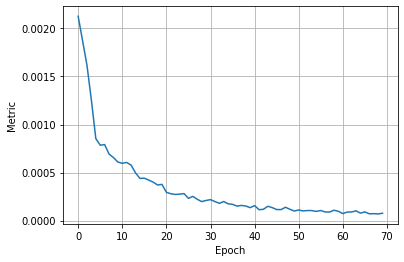

END OF EPOCH 69


In [55]:
attn_student_history = train(attn_student, attn_student_config, attn_student_opt, teacher)

In [56]:
attn_student_history

defaultdict(list,
            {'val_metric': [0.0021264102620335225,
              0.0018711305116082975,
              0.0016148124079039573,
              0.0012520123689358715,
              0.0008539232373468223,
              0.0007850368518441437,
              0.0007910879450914012,
              0.0006928501768109754,
              0.0006558931546410885,
              0.0006099549733616135,
              0.0005964623482806973,
              0.0006051869028442973,
              0.0005769783054283349,
              0.0004971265512453451,
              0.00043902054044796295,
              0.0004413956243852493,
              0.00042159828528487805,
              0.00040038066986019974,
              0.0003703818081699008,
              0.00037709828297245333,
              0.0002943254142485045,
              0.00027984814381670325,
              0.0002722812934838408,
              0.00027533667784537515,
              0.00028136390090230807,
              0.0002315587487902662,

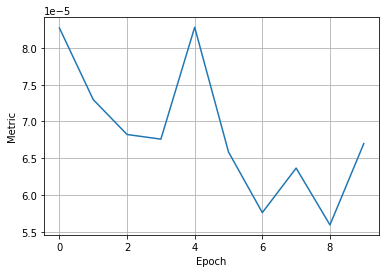

END OF EPOCH 9


In [57]:
attn_student_config.num_epochs = 10
attn_student_finetune_history = train(attn_student, attn_student_config, attn_student_opt, teacher)

In [58]:
attn_student_finetune_history

defaultdict(list,
            {'val_metric': [8.269827437918483e-05,
              7.297117182195642e-05,
              6.823293904254578e-05,
              6.760037899894688e-05,
              8.27997226880639e-05,
              6.585785510525934e-05,
              5.762263944331136e-05,
              6.366776514298766e-05,
              5.595172612059728e-05,
              6.699168914567245e-05]})

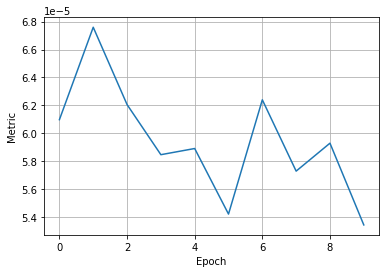

END OF EPOCH 9


In [59]:
attn_student_config.num_epochs = 10
attn_student_finetune2_history = train(attn_student, attn_student_config, attn_student_opt, teacher)

In [60]:
attn_student_finetune2_history

defaultdict(list,
            {'val_metric': [6.098236873148289e-05,
              6.759441145136575e-05,
              6.206249484366591e-05,
              5.8475998747411764e-05,
              5.891759726841478e-05,
              5.4227104869653096e-05,
              6.240264505578986e-05,
              5.730039187393079e-05,
              5.929952031360655e-05,
              5.345132368410727e-05]})

Text(0.5, 0, 'Epoch')

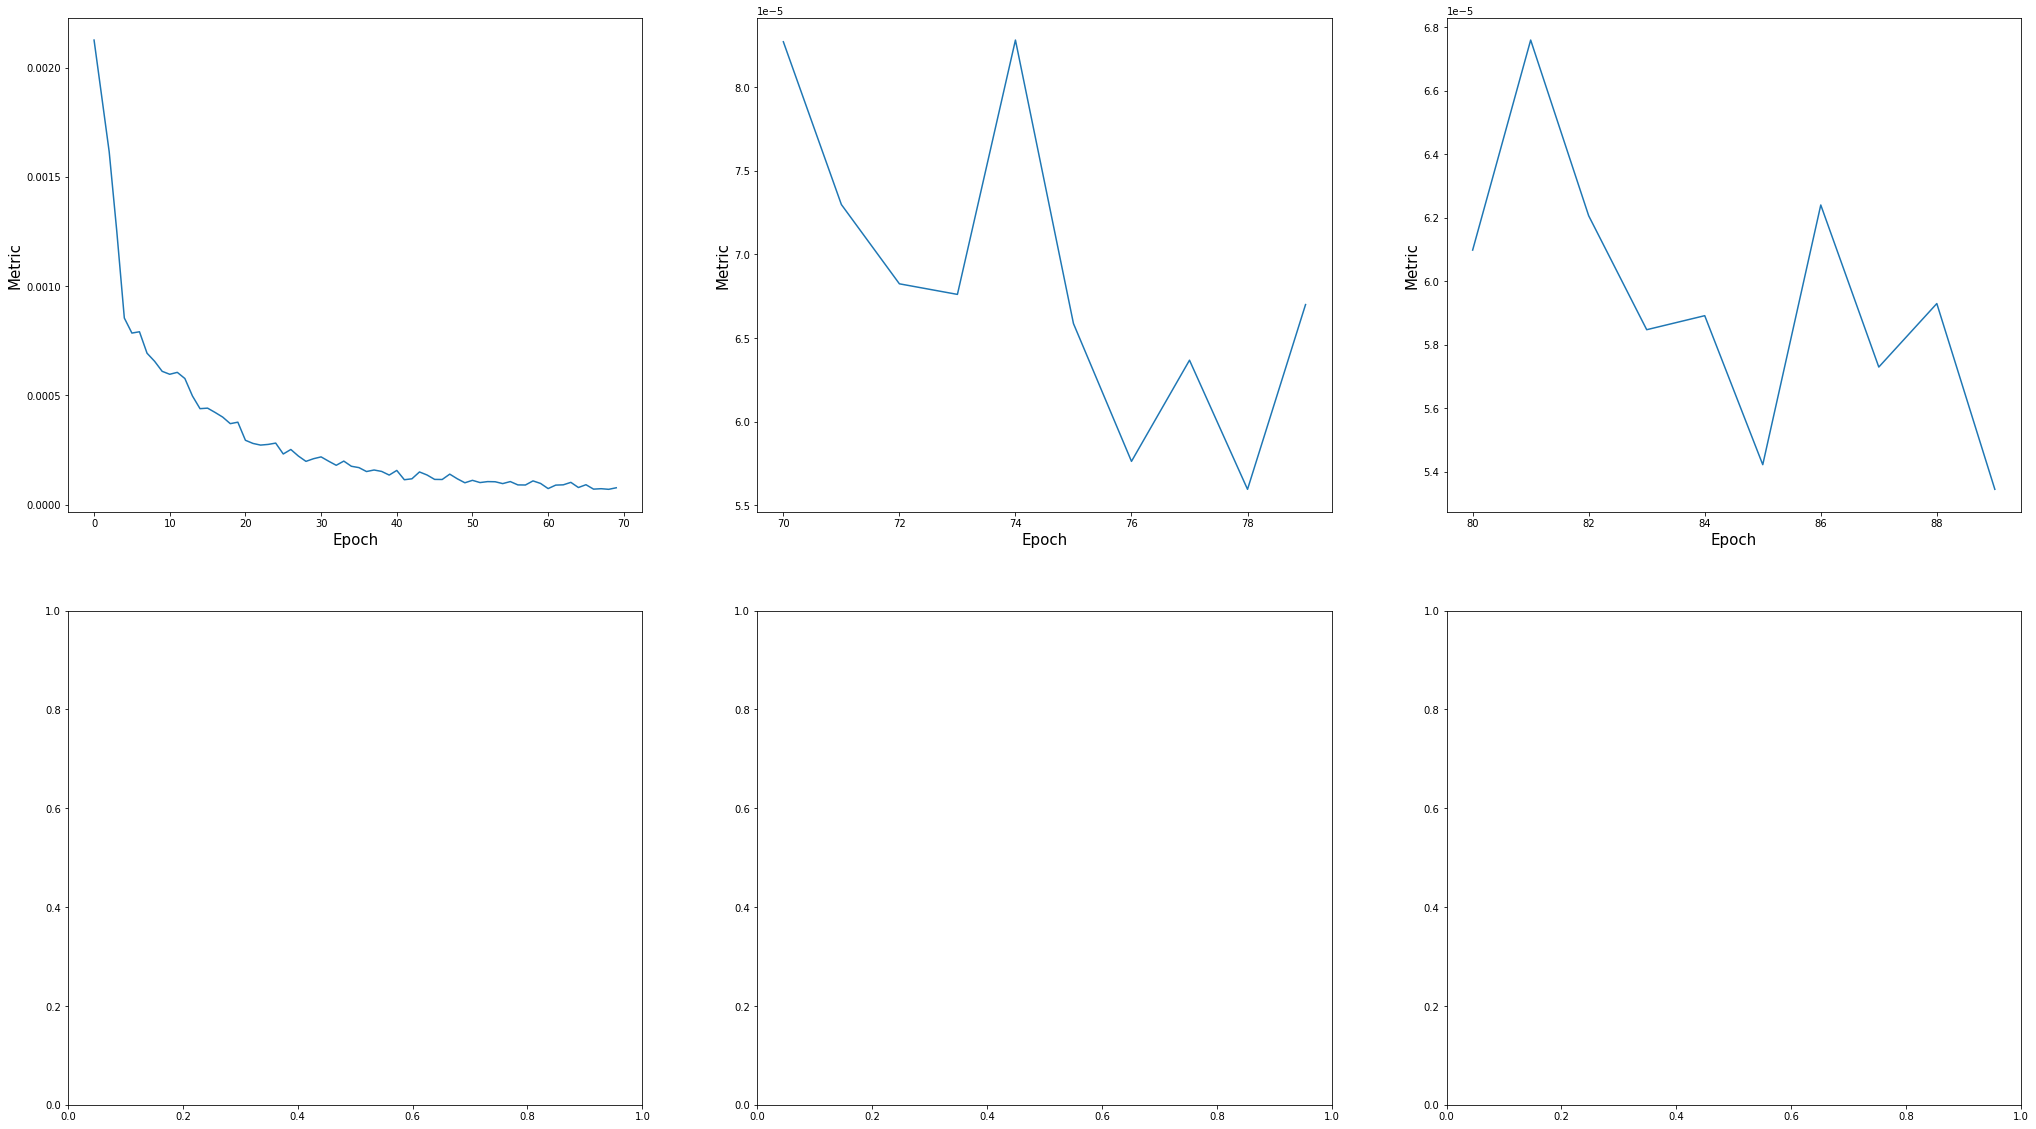

In [86]:
fig, axs = plt.subplots(2, 3, figsize=(35,20))
axs[0, 0].plot(range(len(attn_student_history['val_metric'])), attn_student_history['val_metric'])
axs[0, 0].set_ylabel("Metric", fontsize=15)
axs[0, 0].set_xlabel("Epoch", fontsize=15)

axs[0, 1].plot(
          range(
                  len(attn_student_history['val_metric']),
                  len(attn_student_history['val_metric']) + len(attn_student_finetune_history['val_metric'])
              ),
          attn_student_finetune_history['val_metric']
    )
axs[0, 1].set_ylabel("Metric", fontsize=15)
axs[0, 1].set_xlabel("Epoch", fontsize=15)

axs[0, 2].plot(
          range(
                  len(attn_student_history['val_metric']) + len(attn_student_finetune_history['val_metric']),
                  len(attn_student_history['val_metric']) + len(attn_student_finetune_history['val_metric']) + len(attn_student_finetune2_history['val_metric'])
              ),
          attn_student_finetune2_history['val_metric']
    )
axs[0, 2].set_ylabel("Metric", fontsize=15)
axs[0, 2].set_xlabel("Epoch", fontsize=15)

In [61]:
torch.save(attn_student, "/content/drive/MyDrive/attn_student_hid_s8")
torch.save(attn_student_history, '/content/drive/MyDrive/attn_student_hid_s8_history')

## Validation

In [62]:
attn_student = torch.load('/content/drive/MyDrive/attn_student_hid_s8')
# attn_student_history = torch.load('/content/drive/MyDrive/attn_student_history')

In [63]:
validation(attn_student, val_loader, melspec_val, device="cuda:0")

100%|██████████| 102/102 [00:05<00:00, 18.44it/s]


5.345132368410727e-05

In [64]:
inp = torch.randn(1, 2 * 16_000)
spec = melspec_train(inp.to("cuda:0"))

with Timer(name='first', verbose=True):
    attn_student(spec)

attn_student_macs = profile(attn_student, (spec, ))[0]
attn_student_macs

First | Elapsed time : 0.005749225616455078
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


223806.0

In [65]:
teacher = torch.load('/content/drive/MyDrive/teacher')

In [66]:
inp = torch.randn(1, 2 * 16_000)
spec = melspec_train(inp.to("cuda:0"))

with Timer(name='first', verbose=True):
    teacher(spec)

teacher_macs = profile(teacher, (spec, ))[0]
teacher_macs

First | Elapsed time : 0.0028781890869140625
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


904608.0

In [67]:
print(f"MACs ratio | teacher : attn_student = {teacher_macs / attn_student_macs}")

MACs ratio | teacher : attn_student = 4.04192917079971


In [68]:
teacher_mb = get_size_in_megabytes(teacher)
attn_student_mb = get_size_in_megabytes(attn_student)
print(f"Memory | teacher : attn_student = {teacher_mb/attn_student_mb}")

Memory | teacher : attn_student = 6.242181141727706


# Dark Knowledge Distillation + Dynamic Quantization

В этом эксперименте берётся сдистиллированная модель и применяется динамическая квантизация (в qint8).

Квантизуются веса `torch.nn.Linear`, `torch.nn.GRU` слоёв.

**Результаты:** 

MACs ratio   | teacher : quantized_student = teacher : student = 2.88

Memory ratio | teacher : quantized_student = 6.62

## Quantization

In [ ]:
student = torch.load('/content/drive/MyDrive/student')

In [ ]:
import torch.quantization

set_random_seed()
student.eval()
student.to(torch.device('cpu'))

print(student)
quantized_student_config = TaskConfig(
    hidden_size=16,
    cnn_out_channels=4,
    device=torch.device('cpu')
)
melspec_train_cpu = LogMelspec(is_train=True, config=quantized_student_config)
melspec_val_cpu = LogMelspec(is_train=False, config=quantized_student_config)

quantized_student = torch.quantization.quantize_dynamic(student, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.torch.qint8)

print(quantized_student)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)
CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=16, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  

In [ ]:
torch.save(quantized_student, "/content/drive/MyDrive/quantized_student")

## Validation

In [ ]:
quantized_student = torch.load("/content/drive/MyDrive/quantized_student")

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig(device=torch.device("cpu")))
melspec_val = LogMelspec(is_train=False, config=TaskConfig(device=torch.device("cpu")))

fa_fr_rate = validation(quantized_student, val_loader, melspec_val, device="cpu")

melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

fa_fr_rate

100%|██████████| 102/102 [00:08<00:00, 11.80it/s]


4.6845248511805524e-05

In [ ]:
teacher = torch.load("/content/drive/MyDrive/teacher")

In [ ]:
teacher_mb = get_size_in_megabytes(teacher)
quantized_student_mb = get_size_in_megabytes(quantized_student)
print(f"Memory | teacher : quantized_attn_student = {teacher_mb/quantized_student_mb}")

Memory | teacher : quantized_attn_student = 6.625702202865619


# Dark Knowledge Distillation + Attention Distillation + Dynamic Quantization

В этом эксперименте берётся сдистиллированная модель и применяется динамическая квантизация (в qint8).

Квантизуются веса `torch.nn.Linear`, `torch.nn.GRU` слоёв.

**Результаты:** 

MACs ratio   | teacher : quantized_attn_student = teacher : attn_student = 2.93

Memory ratio | teacher : quantized_attn_student = 6.89

## Quantization

In [71]:
attn_student = torch.load('/content/drive/MyDrive/attn_student_hid_s8')

In [72]:
import torch.quantization

set_random_seed()
attn_student.eval()
attn_student.to(torch.device('cpu'))

print(attn_student)
quantized_attn_student_config = TaskConfig(
    hidden_size=16,
    cnn_out_channels=4,
    device=torch.device('cpu')
)
melspec_train_cpu = LogMelspec(is_train=True, config=quantized_attn_student_config)
melspec_val_cpu = LogMelspec(is_train=False, config=quantized_attn_student_config)

quantized_attn_student = torch.quantization.quantize_dynamic(attn_student, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.torch.qint8)

print(quantized_attn_student)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 8, num_layers=2, batch_first=True, dropout=0.1)
  (attention): SmallAttention(
    (energy): Sequential(
      (0): Linear(in_features=8, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=8, out_features=2, bias=True)
)
CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(72, 8, num_layers=2, batch_first=True, dropout=0.1)
  (attention): SmallAttention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=8, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=2, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
 

In [73]:
torch.save(quantized_attn_student, "/content/drive/MyDrive/quantized_attn_hid_s8_student")

## Validation

In [74]:
quantized_attn_student = torch.load("/content/drive/MyDrive/quantized_attn_hid_s8_student")

In [75]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig(device=torch.device("cpu")))
melspec_val = LogMelspec(is_train=False, config=TaskConfig(device=torch.device("cpu")))

fa_fr_rate = validation(quantized_attn_student, val_loader, melspec_val, device="cpu")

melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

fa_fr_rate

100%|██████████| 102/102 [00:08<00:00, 12.13it/s]


4.8480356549032876e-05

In [76]:
teacher = torch.load("/content/drive/MyDrive/teacher")

In [77]:
teacher_mb = get_size_in_megabytes(teacher)
quantized_attn_student_mb = get_size_in_megabytes(quantized_attn_student)
print(f"Memory | teacher : quantized_attn_student = {teacher_mb/quantized_attn_student_mb}")

Memory | teacher : quantized_attn_student = 8.93598365540138


# Dark Knowledge Distillation + QAT


Ссылки для вдохновения [раз](https://pytorch.org/docs/stable/quantization.html), [два](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html)

Я не смогла победить эту штуку. Не работает ни на gpu, ни на cpu,  а в таких страшных ошибках я пока разбираться не умею...

Должна была применяться `aware trainigt` квантизация `nn.Conv2d` слою (так как динамическая к свёрткам не применяется).

In [ ]:
class QatCRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            # nn.BatchNorm2d(config.cnn_out_channels),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, input):
        input = x = self.quant(input)
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        output = self.dequant(output)
        return output

In [ ]:
set_random_seed()
qat_teacher_config = TaskConfig(
    hidden_size=32
)
qat_teacher = CRNN(qat_teacher_config).to(qat_teacher_config.device)

print(qat_teacher)

qat_teacher_opt = torch.optim.Adam(
    qat_teacher.parameters(),
    lr=qat_teacher_config.learning_rate,
    weight_decay=qat_teacher_config.weight_decay
)

QatCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


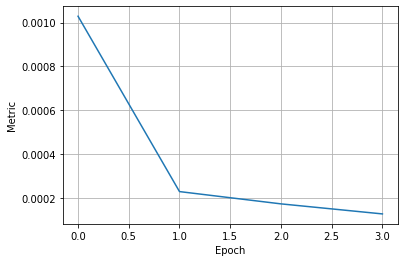

END OF EPOCH 3


In [ ]:
qat_teacher_history = train(qat_teacher, qat_teacher_config, qat_teacher_opt)

In [ ]:
set_random_seed()
qat_student_config = TaskConfig(
    hidden_size=16,
    cnn_out_channels=4,
    num_epochs=3
)
qat_student = QatCRNN(qat_student_config).to(qat_student_config.device)

print(qat_student)

qat_student_opt = torch.optim.Adam(
    qat_student.parameters(),
    lr=qat_student_config.learning_rate,
    weight_decay=qat_student_config.weight_decay
)

QatCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)


In [ ]:
qat_student_history = train(qat_student, qat_student_config, qat_student_opt, qat_teacher)

In [ ]:
fine_tune_qat_student_history = defaultdict(list)
qat_student_config.device = torch.device('cpu')
qat_student.to(qat_student_config.device)
qat_student.eval()
qat_student.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
# torch.ao.quantization.fuse_modules(qat_student.conv, ['0', '1'], inplace=True)
qat_student.train()
qat_student.gru.qconfig = None
qat_student.classifier.qconfig = None
qat_student.attention.qconfig = None
torch.ao.quantization.prepare_qat(qat_student, inplace=True)

# torch.ao.quantization.prepare_qat(qat_student.conv[0], inplace=True)
# torch.ao.quantization.prepare_qat(qat_student.conv[1], inplace=True)

cpu_melspec_train = LogMelspec(is_train=True, config=qat_student_config)
cpu_melspec_val = LogMelspec(is_train=False, config=qat_student_config)

for epoch in range(qat_student_config.num_epochs, qat_student_config.num_epochs + 8):
    train_epoch(qat_student, qat_student_opt, train_loader, cpu_melspec_train, device=qat_student_config.device)

    if epoch > qat_student_config.num_epochs + 3:
        # Freeze quantizer parameters
        qat_student.apply(torch.ao.quantization.disable_observer)
    if epoch > qat_student_config.num_epochs + 2:
        # Freeze batch norm mean and variance estimates
        qat_student.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

    # Check the accuracy after each epoch
    eval_student = torch.ao.quantization.convert(qat_student.eval(), inplace=False)
    eval_student.eval()
    au_fa_fr = validation(eval_student, val_loader,
                              cpu_melspec_val, qat_student_config.device)
    fine_tune_qat_student_history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(fine_tune_qat_student_history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF FINE-TUNE EPOCH', epoch - qat_student_config.num_epochs)

  0%|          | 0/102 [00:00<?, ?it/s]


NotImplementedError: ignored

In [ ]:
qat_student

QatCRNN(
  (conv): Sequential(
    (0): Conv2d(
      1, 4, kernel_size=(5, 20), stride=(2, 8)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0008, 0.0008, 0.0008, 0.0008]), zero_point=tensor([0, 0, 0, 0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([-0.0990, -0.0997, -0.1003, -0.0997]), max_val=tensor([0.0966, 0.1006, 0.0973, 0.0986]))
      )
      (activation_post_process): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.3350]), zero_point=tensor([45], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
        (activation_post_process): MovingAverageMinMaxObserver(min_val=-15.1755533218

# Best Result Representation

**Dark Knowledge Distillation + Attention Distillation + Dynamic Quantization**
`hidden_size`=8!!

Вставьте нужные пути до моделей.

In [87]:
PATH_TO_BEST_MODEL = "/content/drive/MyDrive/quantized_attn_hid_s8_student"
PATH_TO_BEST_MODEL_WITHOUT_QUANT = "/content/drive/MyDrive/attn_student_hid_s8"
PATH_TO_BASE_MODEL = "/content/drive/MyDrive/teacher"

In [88]:
best_model = torch.load(PATH_TO_BEST_MODEL)
base_model = torch.load(PATH_TO_BASE_MODEL)
prev_best_model = torch.load(PATH_TO_BEST_MODEL_WITHOUT_QUANT)

In [91]:
base_model_mb = get_size_in_megabytes(base_model)
best_model_mb = get_size_in_megabytes(best_model)

inp = torch.randn(1, 2 * 16_000)
spec = melspec_train(inp.to("cuda:0"))

best_model_macs = profile(prev_best_model, (spec, ))[0]
base_model_macs = profile(base_model, (spec, ))[0]

print()
print(f"Memory compression ratio (base_model : best_model) = {base_model_mb / best_model_mb}")
print(f"MACs compression ratio (base_model : best_model) = {base_model_macs / best_model_macs}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

Memory compression ratio (base_model : best_model) = 9.140887034987657
MACs compression ratio (base_model : best_model) = 4.04192917079971
